<h1 align="center">Volume 4: Spectral 1.</h1>
Caelan Osman

Jan. 7, 2021

In [12]:
import numpy as np
import sympy as sy
from matplotlib import pyplot as plt
from scipy.interpolate import barycentric_interpolate
from scipy.interpolate import BarycentricInterpolator
from scipy.integrate import quad
from scipy.integrate import simpson
from numpy import linalg as la
from scipy.optimize import root
from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook

# Setup

In [2]:
def cheb(N):
    x = np.cos((np.pi/N)*np.linspace(0,N,N+1))
    x.shape = (N+1,1)
    lin = np.linspace(0,N,N+1)
    lin.shape = (N+1,1)
    
    c = np.ones((N+1,1))
    c[0], c[-1] = 2., 2.
    c = c*(-1.)**lin
    X = x*np.ones(N+1) # broadcast along 2nd dimension (columns)
    
    dX = X - X.T
    
    D = (c*(1./c).T)/(dX + np.eye(N+1))
    D = D - np.diag(np.sum(D.T,axis=0))
    x.shape = (N+1,)
    # Here we return the differentiation matrix and the Chebyshev points,
    # numbered from x_0 = 1 to x_N = -1
    return D, x

# Problem 1

Use the differentiation matrix to numerically approximate the derivative of u(x)) on a grid of N Chebychev points where N = 6, 8, and 10.
Then use barycentric interpolation (scipy.interpolate.barycentric_interpolate) to
approximate u0 on a grid of 100 evenly spaced points.
Graphically compare your approximation to the exact derivative

<IPython.core.display.Javascript object>


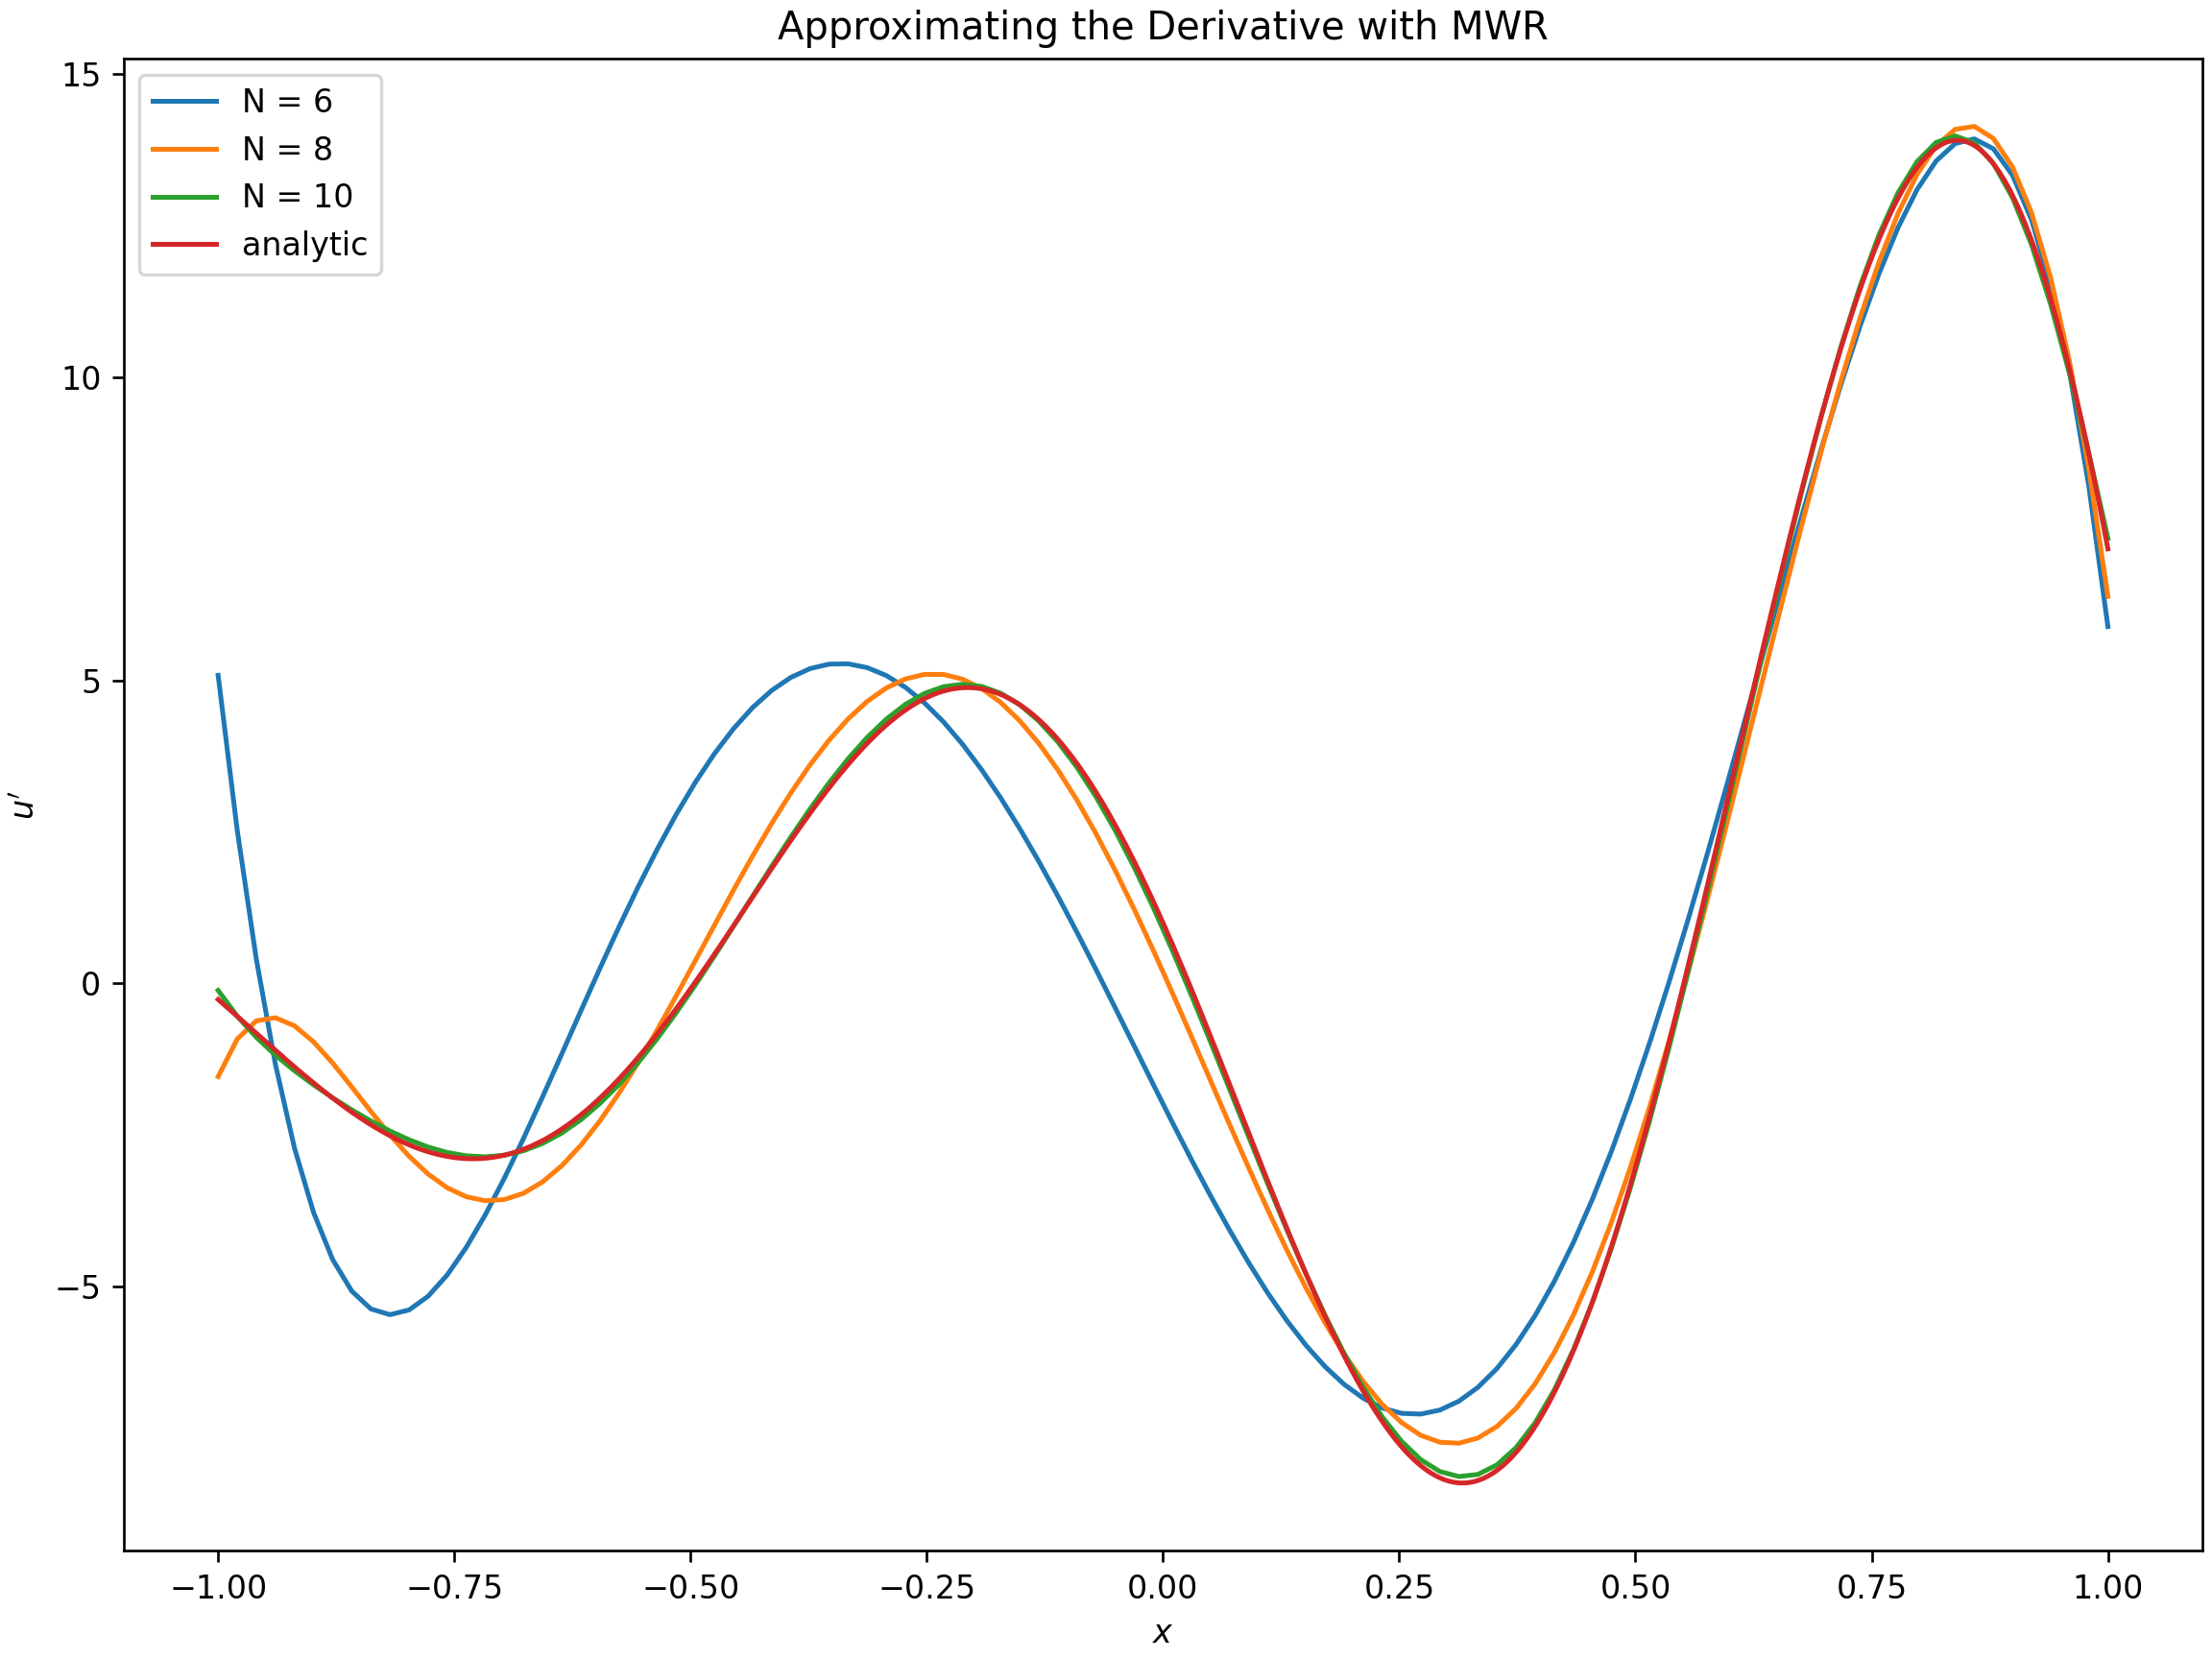

In [3]:
def problem1():
    #define the expression and the analytic derivative
    x = sy.symbols('x')
    expr = sy.exp(x)*sy.cos(6*x)
    u = sy.lambdify(x, expr, 'numpy')
    Du = sy.lambdify(x, sy.diff(expr, x), 'numpy')

    #prepare figure for plotting
    fig = plt.figure(constrained_layout=True)
    fig.set_dpi(150)
    ax = fig.add_subplot(111)
    #now we go through and get our estimates
    N_vals = [6, 8, 10]
    for N in N_vals:
        #get differential matrix and G-L points
        D, x = cheb(N)
        #define our U vector
        U = u(x)
        #calculate Uprime
        up_cheby = D@U
        #get 100 evenly spaced points
        even_points = np.linspace(np.min(x), np.max(x), 100)
        #get the interpolator
        barry = barycentric_interpolate(x, up_cheby, even_points)
        #now plot
        ax.plot(even_points, barry, label=r'N = ' + str(N))
        ax.legend(loc='best')
    
    #define domain for evaluation (chebyshev polynomials are valid on [-1, 1])
    domain = np.linspace(-1, 1, 1000)
    ax.plot(domain, Du(domain), label='analytic')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$u^{\prime}$')
    ax.set_title('Approximating the Derivative with MWR')
    ax.legend(loc='best')
    plt.show()

    return

problem1()

# Problem 2

Use the pseudospectral method to solve the boundary value problem.
Use N = 8 in the cheb(N) method and use barycentric interpolation to approximate u on
100 evenly spaced points. Compare your numerical solution with the exact solution.

<IPython.core.display.Javascript object>


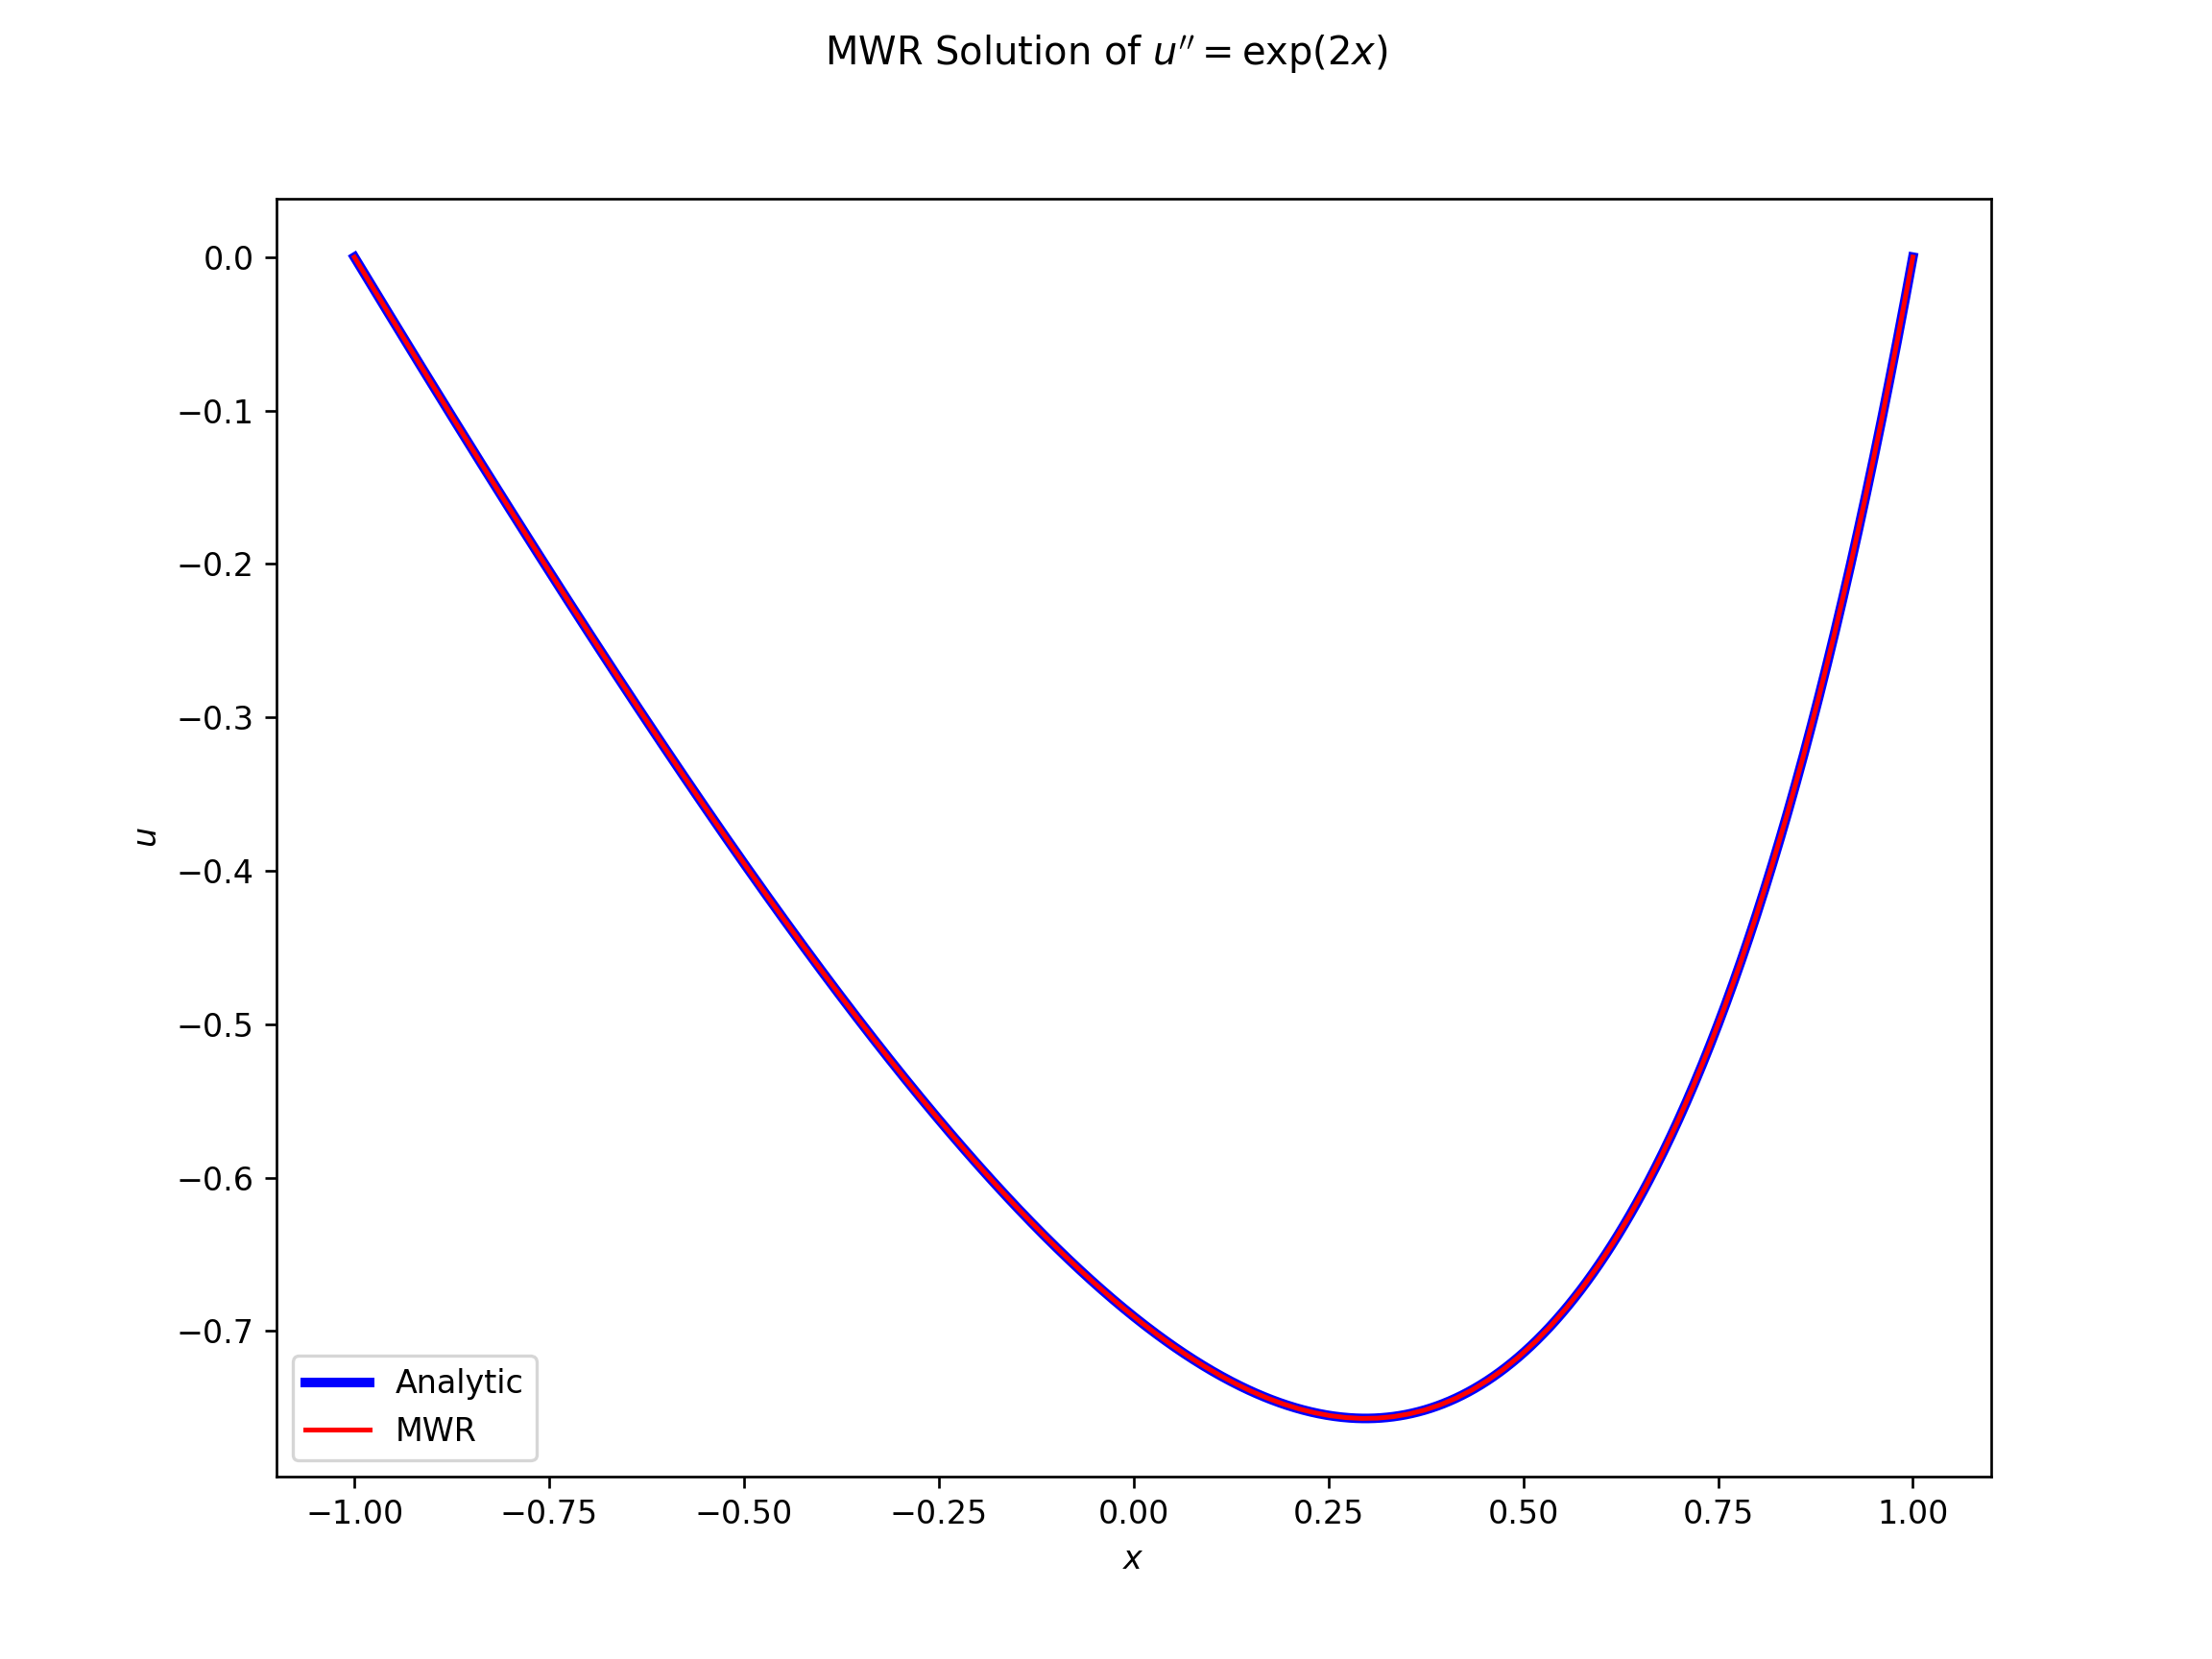

In [4]:
def problem2(N=8):
    #forcing function used in the 2nd order ODE
    f = lambda x: np.exp(2*x)
    #the domain for which we are solving
    domain = np.linspace(-1, 1, 1000)
    #the exact solution
    analytic = lambda x: (-np.cosh(2) - np.sinh(2)*x + np.exp(2*x)) /4
    #get differentiation matrix
    D, x = cheb(N)
    #define the force vector F
    F = f(x)
    #enforce boundary conditions
    D2 =  D@D
    D2[0,:], D2[-1,:] = 0, 0
    D2[0,0], D2[-1,-1] = 1, 1
    F[0], F[-1] = 0, 0
    #solve the system (i.e get discrete values of U at cheby points)
    u_cheby = la.solve(D2, F)
    #now we try to approximate U using 100 evenly spaced points
    even_points = np.linspace(np.min(x), np.max(x), 100)
    barry = barycentric_interpolate(x, u_cheby, even_points)

    #now we plot everything
    fig = plt.figure()
    fig.set_dpi(150)
    ax = fig.add_subplot(111)
    ax.plot(domain, analytic(domain), 'b-', linewidth=3, label='Analytic')
    ax.plot(even_points, barry, 'r-', linewidth=1.5, label='MWR')
    ax.legend(loc='best')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$u$')
    plt.suptitle('MWR Solution of ' + r"$u^{\prime\prime} = \exp(2x)$")
    plt.show()

    return

problem2(N=8)

# Problem 3

Use the pseudospectral method to solve the boundary value problem.
Use N = 8 in the cheb(N) method and use barycentric interpolation to approximate u on
100 evenly spaced points.

<IPython.core.display.Javascript object>


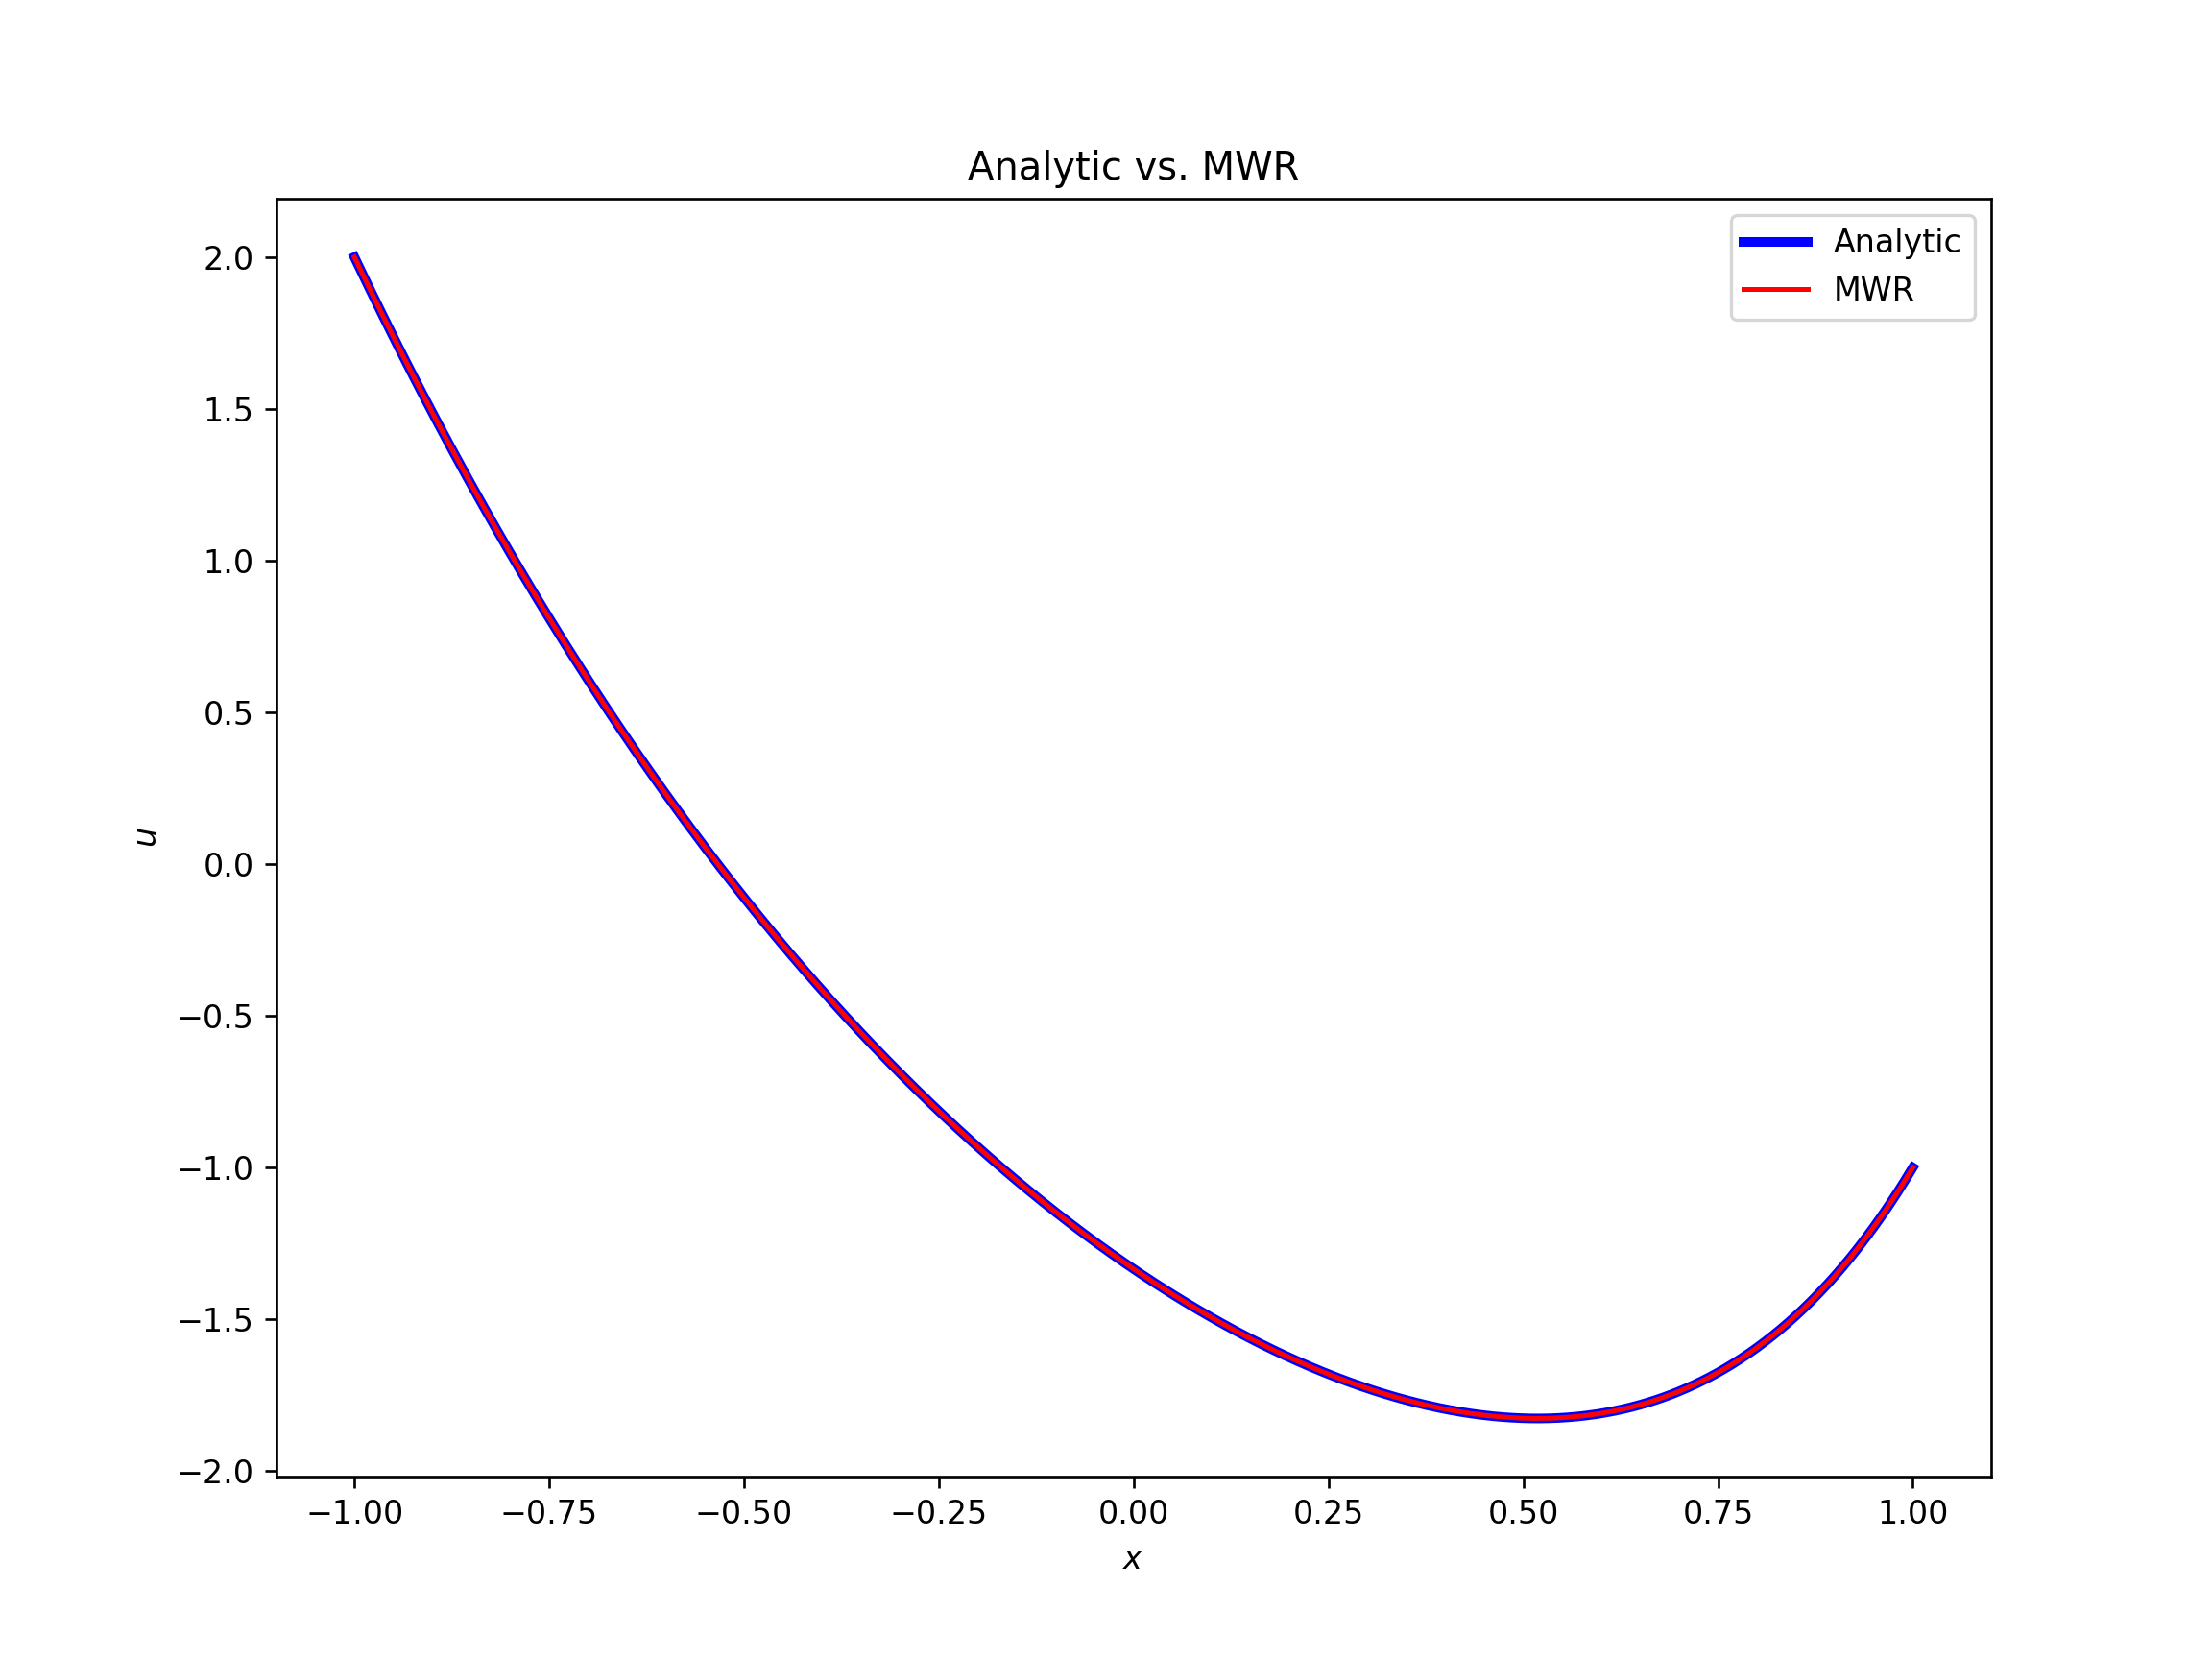

In [5]:
def problem3(N = 8):
    #analytic solution, used for testing (gotten from mathematica)
    analytic = lambda t: (np.exp(-3-t)*(-np.exp(1) + 36 *np.exp(4)
                                        + np.exp(7) + np.exp(t) 
                                        - 24*np.exp(3 + t) - 12 
                                        * np.exp(5+t) -np.exp(8+t) 
                                        - np.exp(3+4*t) + np.exp(5+4*t)))\
                                        / (12 *(-1 + np.exp(2)))
    #define domain for analytic solution
    domain = np.linspace(-1, 1, 1000)
    
    #define forcing function
    f = lambda x: np.exp(3*x)

    #get differentiation matrix
    D, x = cheb(N)
    #get D^2
    D2 =  D@D
    #define the the forcing vector F
    F = f(x)
    #enforce boundary conditions on first matrix
    D[0, :], D[-1, :] = 0, 0
    D[0, 0], D[-1, -1] = 0.5, 0.5
    #enforce boundary conditions on D^2
    D2[0,:], D2[-1,:] = 0, 0
    D2[0, 0], D2[-1,-1] = 0.5, 0.5
    #enforce boundary conditions on the forcing vector
    F[0], F[-1] = -1, 2
    #solve the system
    u_cheby = la.solve(D2 + D, F)
    #now we interpolate on 100 evenly spaced points
    even_points = np.linspace(np.min(x), np.max(x), 100)
    barry = barycentric_interpolate(x, u_cheby, even_points)

    #now we plot
    fig = plt.figure()
    fig.set_dpi(150)
    ax = fig.add_subplot(111)
    ax.plot(domain, analytic(domain), 'b-', linewidth=3, label='Analytic')
    ax.plot(even_points, barry, 'r-', linewidth=1.5, label='MWR')
    ax.legend(loc='best')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$u$')
    ax.set_title('Analytic vs. MWR')
    plt.show()

    return

problem3(N=8)

# Problem 4

$u'' = \lambda \sinh(\lambda u)$ whre $u(x)$ $x\in(0, 1)$

Use the pseudospectral method to solve the boundary value problem
for several values of λ: λ = 4, 8, 12. Begin by transforming this BVP onto the domain −1 <
x < 1. Use N = 20 in the cheb(N) method and use barycentric interpolation to approximate
u on 100 evenly spaced points

In order to solve this problem using the pseudospectral method we first need to transform the problem to the domain $[-1, 1]$.
We will assume a linear change of variables, that is, a function of the form $y=ax +b$ where $y:[-1, 1]\to [0, 1]$.
This gives us two equations:

\begin{align}
&y(-1) = 0= -a +b\\
&y(1) = 1= a+ b
\end{align}

Which leads to the matrix equation

\begin{align}
\begin{bmatrix}
-1 & 1\\
1 & 1
\end{bmatrix}
\begin{bmatrix}
a\\ b
\end{bmatrix}
=
\begin{bmatrix}
0 \\1
\end{bmatrix}
\implies
\begin{bmatrix}
a\\ b
\end{bmatrix}
=
\begin{bmatrix}
\frac12\\ \frac12
\end{bmatrix}
\end{align}

Remember the chain rule though.

\begin{align*}
(u(y(x)))'' &= \left(u'(y(x)) y'(x)\right)'\\
            &= (u'(y(x))'\cdot y'(x) + u'(y(x))\cdot y''(x)\\
            &= u''(y(x)) \cdot y'(x)^2
\end{align*}

Where the final equality follows from noticing that $y''(t) =0$ because $y$ is linear.
Also note that $y'(t) = \frac12$ so that $y'(t)^2 = \frac14$.
This allows us to instead solve the following differential equation

\begin{align}
&  u''(y) =\frac\lambda 4  \sinh(\lambda u(y))\\
&u(y(0)) = 0,\quad u(y(1)) =1
\end{align}

<IPython.core.display.Javascript object>


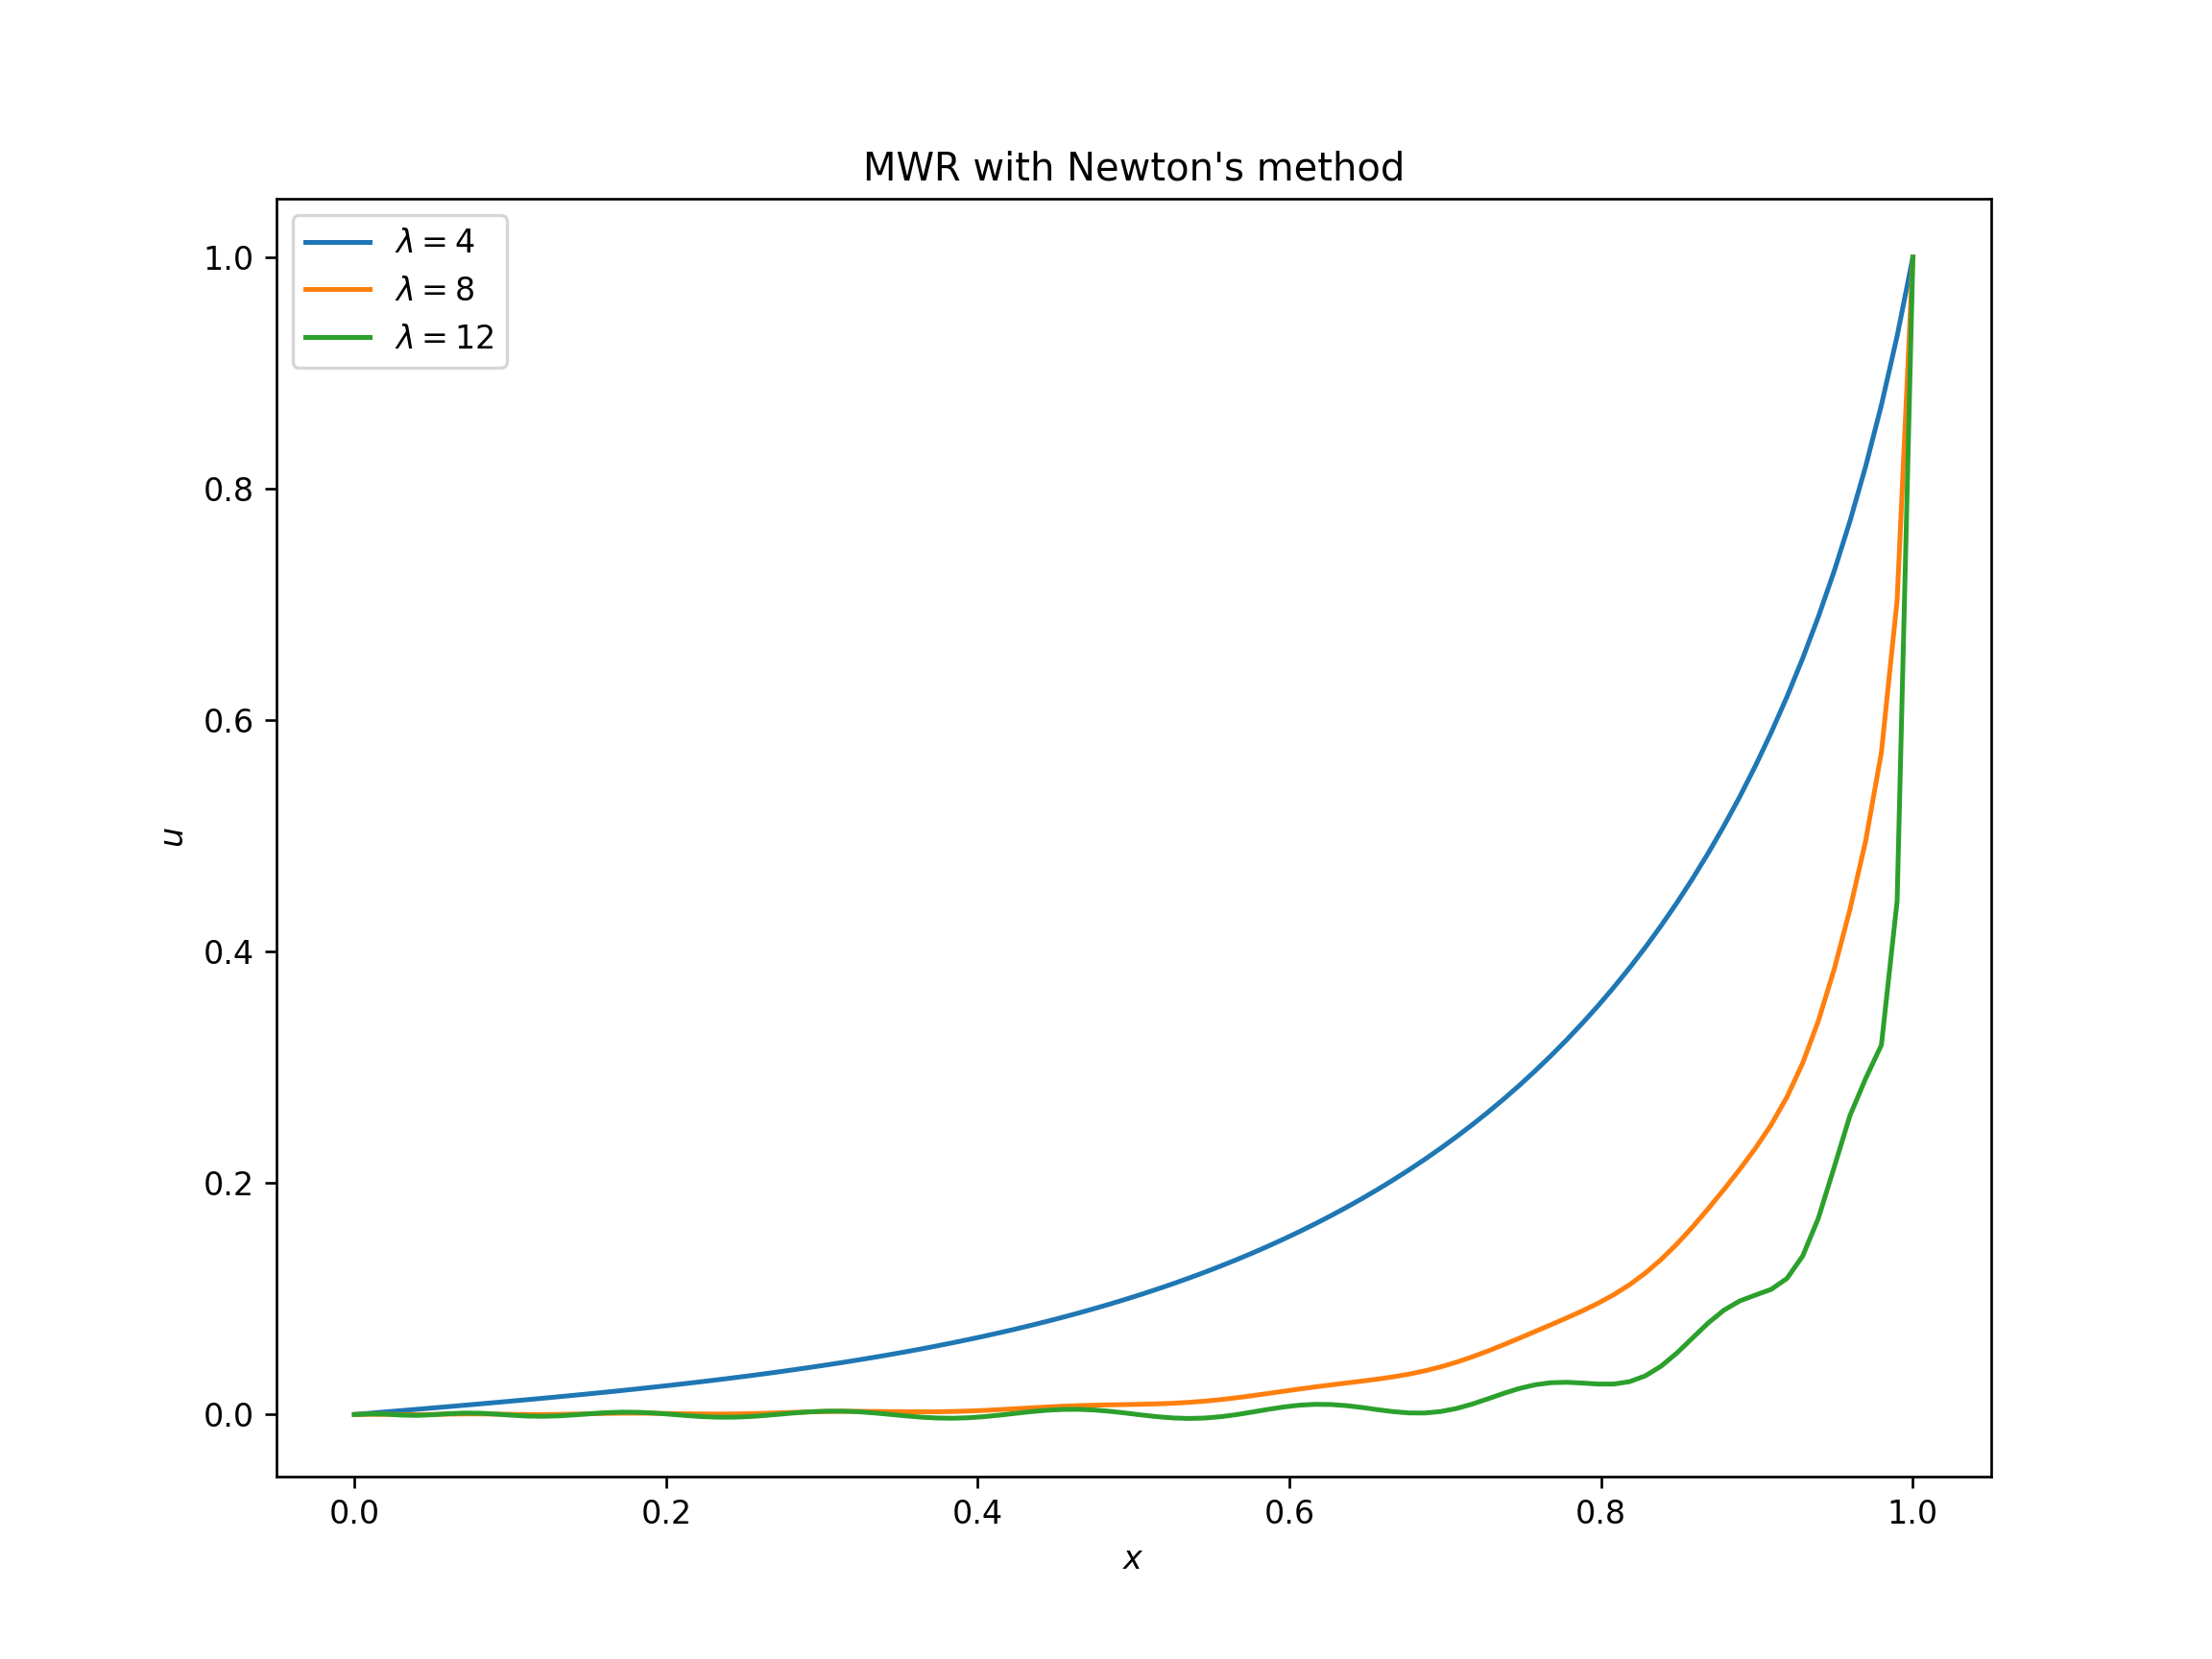

In [6]:
#define function for BVP solving
def BVP_sol(N, lam = 4):
    D, x = cheb(N)
    D2 = D@D
    guess = np.ones_like(x)
    #define function
    def F(u):
        result =  4*D2@u - lam*np.sinh(lam*u)
        result[0] = u[0]-1
        result[-1] = u[-1]
        return result 

    solution = root(F, guess).x

    return x, solution

def problem4(N=20):
    #set up figure
    fig = plt.figure()
    fig.set_dpi(150)
    ax = fig.add_subplot(111)
    λ_vals = [4, 8, 12]
    for λ in λ_vals:
        x, u = BVP_sol(N, lam=λ)
        even_grid = np.linspace(np.min(x), np.max(x), 100)
        bary = barycentric_interpolate(x, u, even_grid)
        ax.plot(even_grid/2+1/2, bary, label=r'$\lambda = $' + str(λ))
        ax.legend(loc='best')
        
    ax.set_title(r"MWR with Newton's method")
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$u$')
    plt.show()

    return

problem4()

# Problem 5

Find the function y(x) that satisies y(−1) = 1, y(1) = 7, and whose surface of
revolution (about the x-axis) minimizes surface area. Compute the surface area, and plot the
surface. Use N = 50 in the cheb(N) method and use barycentric interpolation to approximate
u on 100 evenly spaced points.
Below is sample code for creating the 3D wireframe figure.

<IPython.core.display.Javascript object>


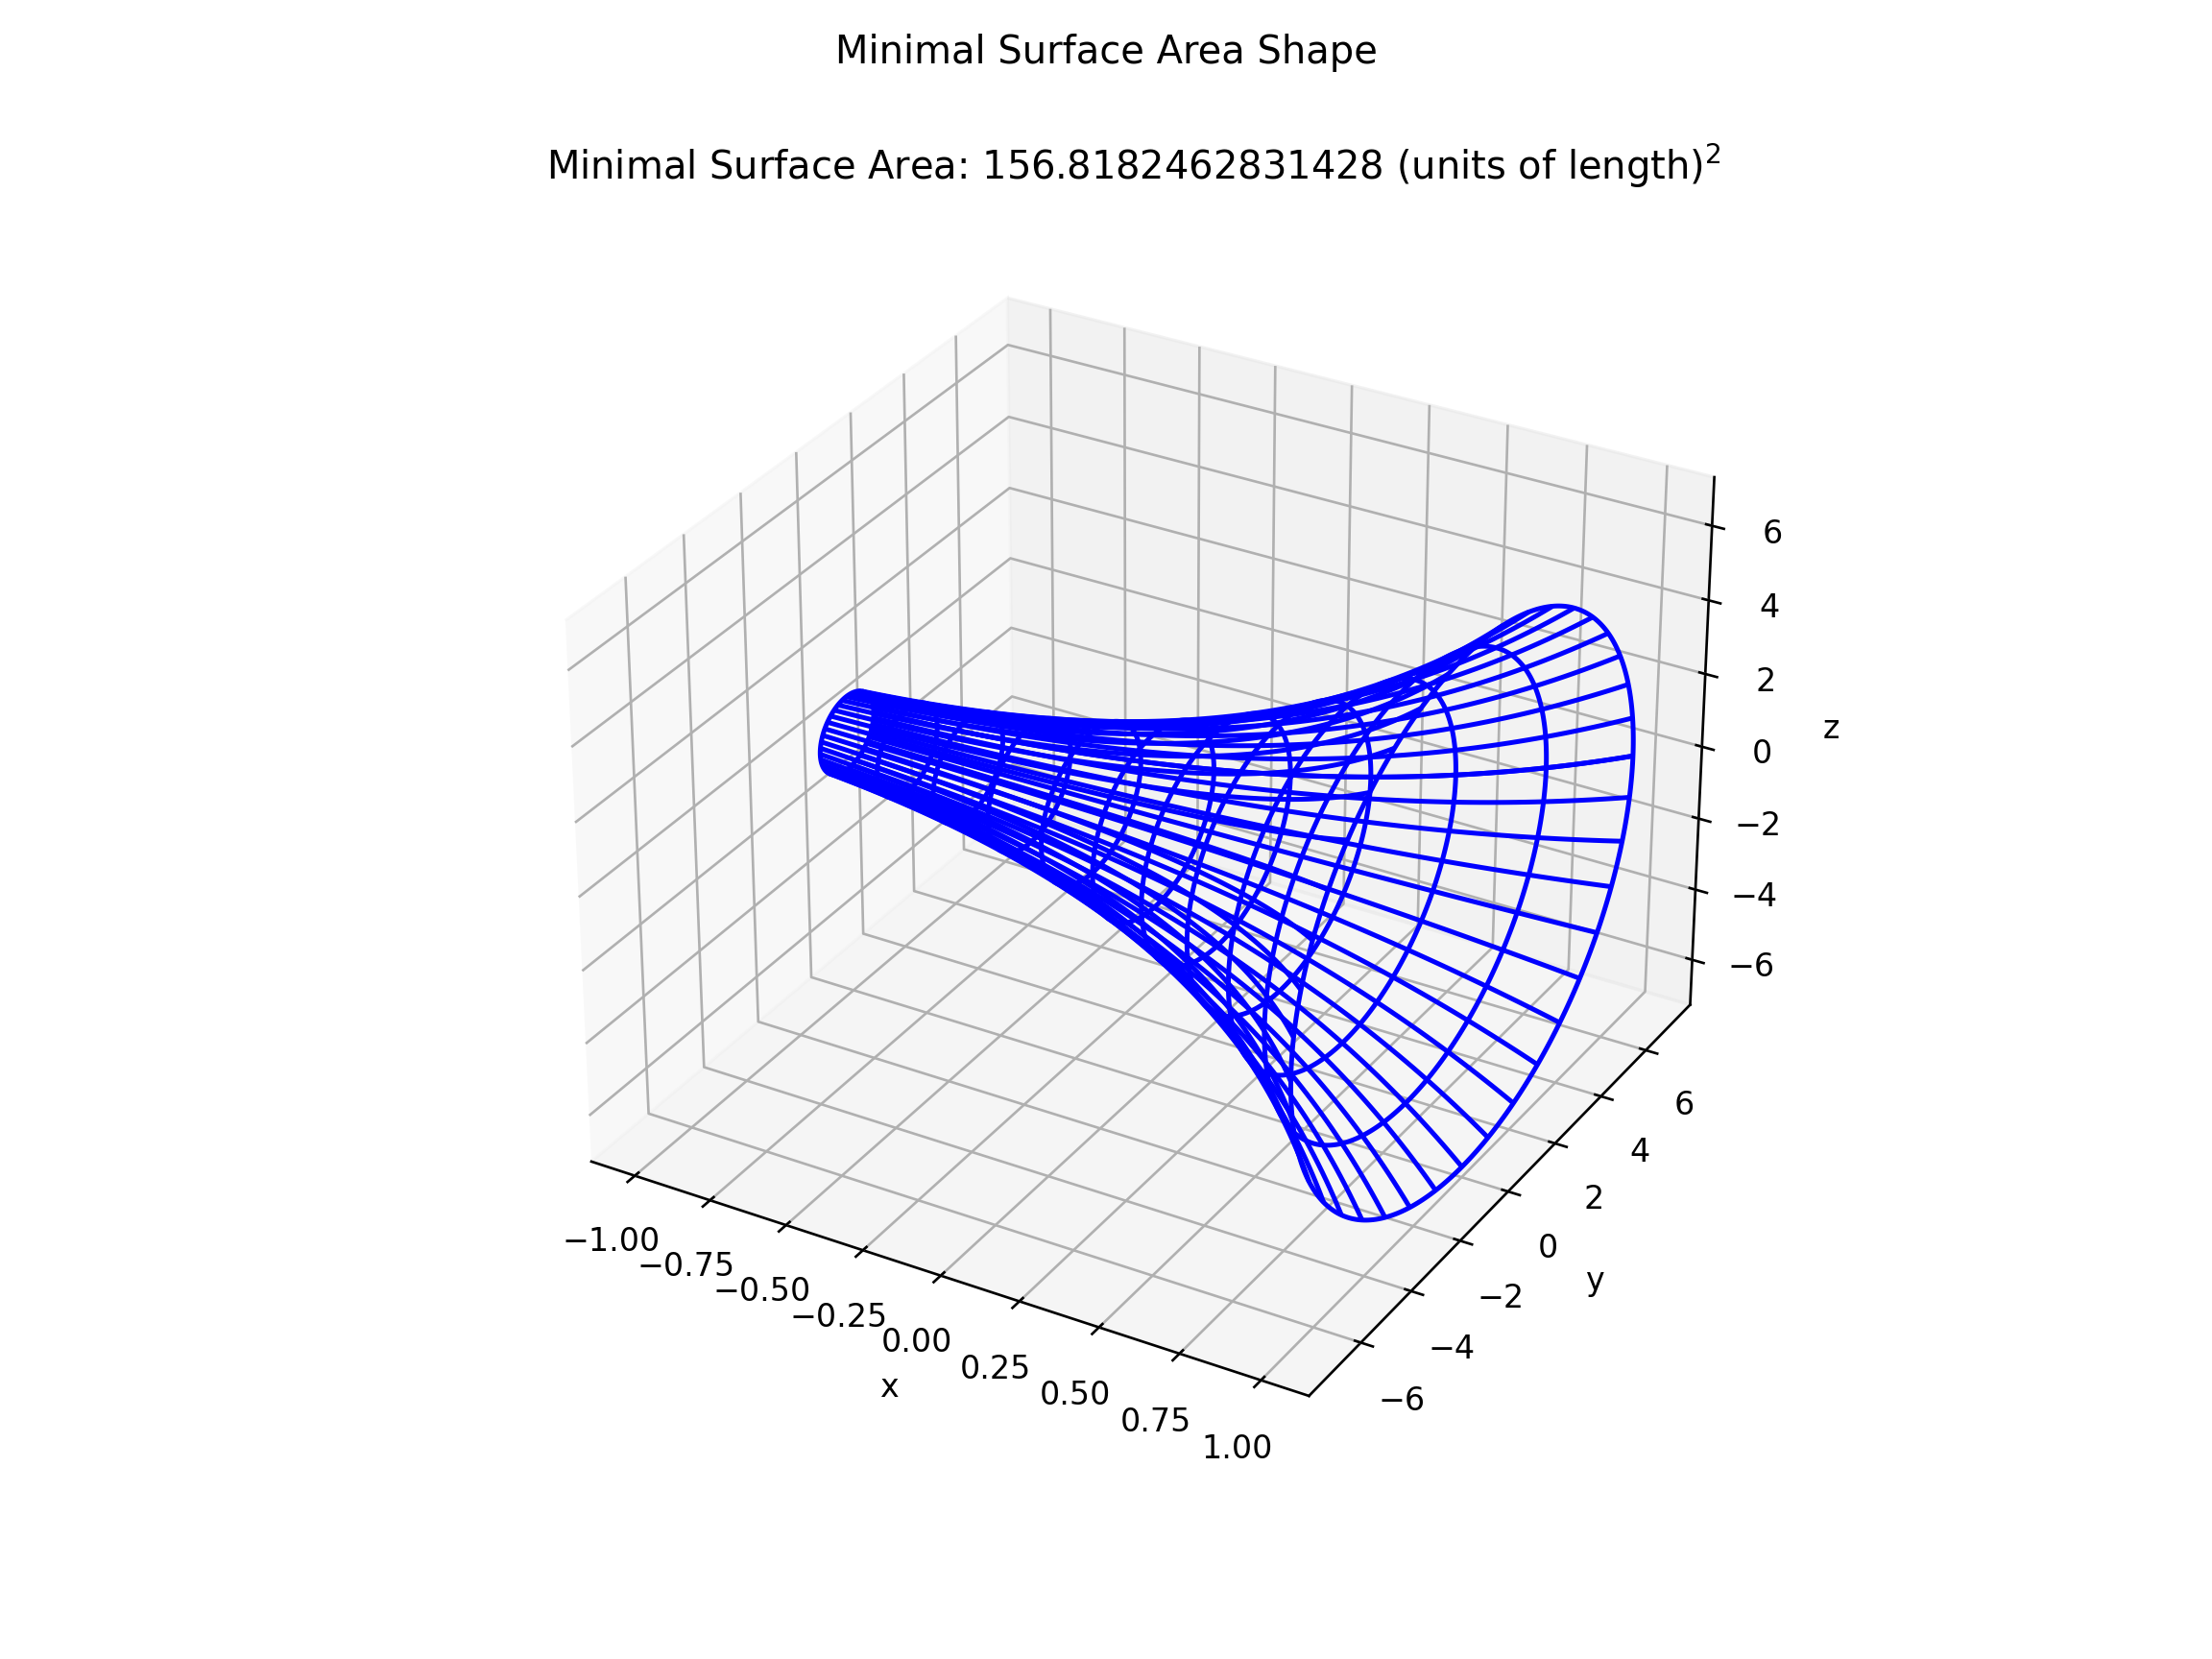

The surface area is: 156.8182462831428


In [19]:
def BVP_sol(N):
    #get differential matrix and x
    D, x = cheb(N)
    #square the differential matrix
    D2 = D@D
    #get our guess
    guess = np.ones_like(x) *2
    
    def F(u):
        #our result use array broad-casting
        result =  (u*(D2@u)) - (D@u)**2 - 1
        #set our boundary conditions
        result[0] = u[0]-7
        result[-1] = u[-1]-1
        #return the result
        return result 
    #use newton's method to get root finding
    solution = root(F, guess).x
    #return x and our solution
    return x, solution, D

def problem5(N=50):
    
    #solve
    x, u, D = BVP_sol(N)
    #create our even grid
    even_grid = np.linspace(np.min(x), np.max(x), 100)
    #interpolate
    bary = barycentric_interpolate(x, u, even_grid)
    
    #now we plot our wireframe
    lin = np.linspace(-1, 1, 100)
    theta = np.linspace(0,2*np.pi,401)
    X, T = np.meshgrid(lin, theta)
    Y, Z = bary*np.cos(T), bary*np.sin(T)
    fig = plt.figure()
    fig.set_dpi(150)
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10, color='blue')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.suptitle('Minimal Surface Area Shape')
    
    
    #now we calculate the surface area
    y = BarycentricInterpolator(x, u)
    Dy = BarycentricInterpolator(x, D@u)
    func = lambda x: 2*np.pi*y(x) * np.sqrt(1 + (Dy(x))**2)
    SA, _ = quad(func, -1, 1)
    ax.set_title('Minimal Surface Area: ' + str(SA) + r' (units of length$)^2$')
    plt.show()
    
    return SA

SA = problem5()
print('The surface area is: ' + str(SA), sep='\n')